# Group Meeting 6

Local Information 

### Readings 

Extra credit reading: Joe Lizier's PhD thesis. You don't have to read it all, obviously, but give it a look over.

https://lizier.me/joseph/publications/2010-Lizier-LocalInfoDynamics-Thesis.pdf


## Local Information

Recall from way back in the begining of this meeting, we discussed how (almost) every measure used in information theory can be formalized in terms of an expected value of some distribution. For example, the basic Shannon entropy is:

\begin{equation}
H(X) = E[-\log(x_i)]
\end{equation}

And the mutual information is:

\begin{equation}
MI(X,Y) = E[\log\frac{P(x_i,y_i)}{P(x_i)P(y_i)}]
\end{equation}

This also works for derivatives of mutual information, such as active information storage and transfer entropy. The result is that the standard measures we look at are actually averages over multiple instances of the variable in question. We can "unroll" these averages to get a specific measure of the information content of a particular state, or moment in time. 

For a very simple example, consider the entropy of a distribution:

Text(0.5, 1.0, 'Probability Distribution')

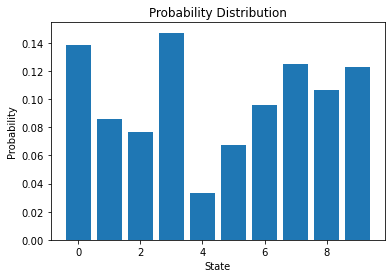

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from scipy.stats import entropy, zscore
from collections import Counter

P = np.random.randint(0,100,10)
P = P/np.sum(P)

plt.bar(np.arange(10), P)
plt.xlabel("State")
plt.ylabel("Probability")
plt.title("Probability Distribution")

The entropy is easy:

In [2]:
ent = entropy(P, base=2)
print("H =", ent, "bit")

H = 3.232100522059773 bit


We can also look at the Shannon information content of each possible outcome to get a measure of how "surprising" each individual outcome is.

Text(0.5, 1.0, 'Surprise Distribution')

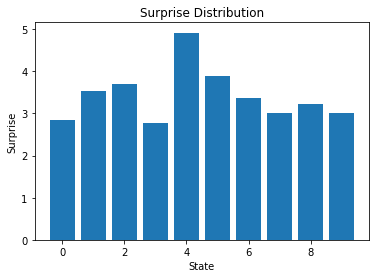

In [3]:
sup = -np.log2(P)

plt.bar(np.arange(10), sup)
plt.xlabel("State")
plt.ylabel("Surprise")
plt.title("Surprise Distribution")

We can do the same thing using mutual information between two time-series. Consider our usual BOLD data:

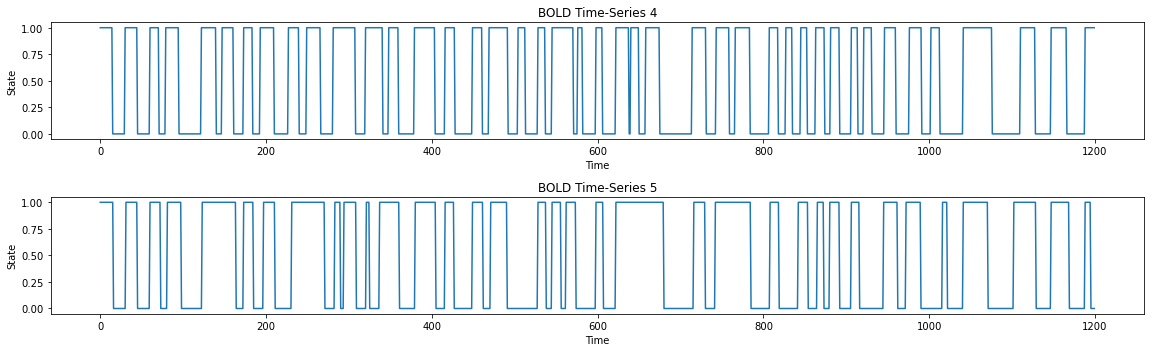

In [4]:
data = np.load("data/HCP_BOLD.npz")
bold = zscore(data["signal"], axis=1) #Z-scored for data-hygiene reasons.
bold[bold < 0] = int(0)
bold[bold > 0] = int(1)

bold=bold.astype("int")

plt.figure(figsize=(16,5))
plt.subplot(2,1,1)
plt.plot(bold[4][:])
plt.xlabel("Time")
plt.ylabel("State")
plt.title("BOLD Time-Series 4")

plt.subplot(2,1,2)
plt.plot(bold[5][:])
plt.xlabel("Time")
plt.ylabel("State")
plt.title("BOLD Time-Series 5")
plt.tight_layout()

We can easily calculate the average mutual information between these two time-series:

In [5]:
H_4 = entropy(list(Counter(bold[4]).values()), base=2)
H_5 = entropy(list(Counter(bold[5]).values()), base=2)
H_joint = entropy(list(Counter(zip(bold[4], bold[5])).values()), base=2)

print("Mutual Information:", H_4+H_5+H_joint, "bit")


Mutual Information: 3.6638862651694684 bit


But what if we want more temporal detail, beyond what you get just smashing everything into a single number. For that we can use the local mutual information (LMI)

\begin{equation}
LMI(x_i, y_i) = \log\big(\frac{P(x_i,y_i)}{P(x_i)P(y_i)}\big)
\end{equation}

This will give us an LMI value for every moment in the time-series. Note that two different things can happen here:

1) If $P(x_i,y_i)>P(X_i)P(y_i)$, then LMI > 0. This means that the probability of two particular states ($x_i$,$y_i$) co-occuring is greater when considered jointly than if we only considered the marginals. 

2) Alternately, if $P(x_i,y_i)<P(x_i)P(y_i)$, then LMI < 0. This is important: while the average mutual information is *always* greater than, or equal to, zero, the LMI has no such restriction. When LMI < 0, you can think of this as *misinformation*, i.e. the joint state of the system would be more likely if the time-series were uncoupled than if they were coupled. 

This ability to discriminate between "true" information and "misinformation" can give us key insights into how the system is behaving at a given moment: do the elements behave as if they are coupled? Or as if they are uncoupled (which we know they are not, if MI > 0).

Let's visualize this:

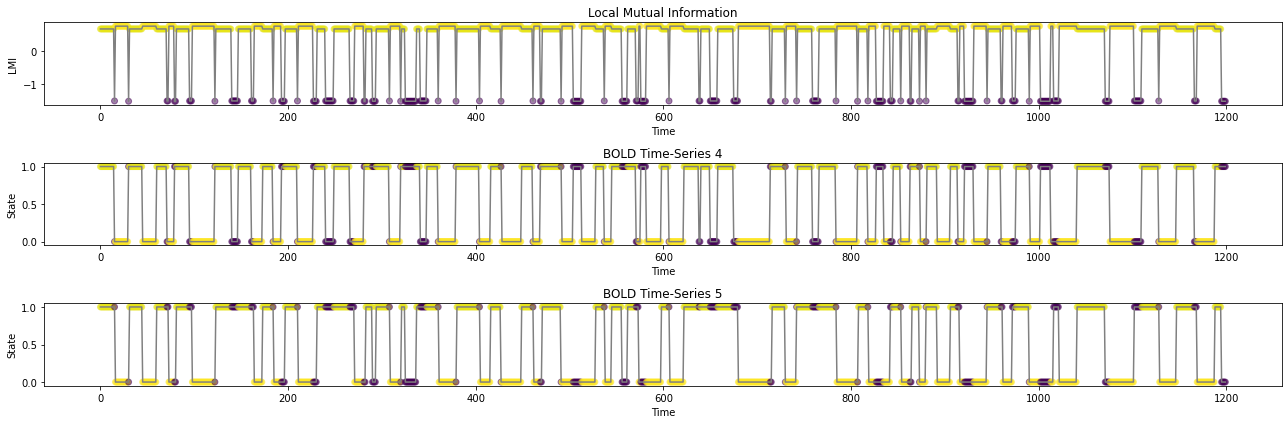

In [6]:
def LMI(X, Y):
    probs_X = Counter(X)
    probs_Y = Counter(Y)
    probs_joint = Counter(zip(X,Y))
    
    probs_X = {i:probs_X[i] / sum(probs_X.values()) for i in probs_X.keys()}
    probs_Y = {i:probs_Y[i] / sum(probs_Y.values()) for i in probs_Y.keys()}
    probs_joint = {i:probs_joint[i] / sum(probs_joint.values()) for i in probs_joint.keys()}
    
    lmi = np.zeros(len(X))
    for i in range(len(X)):
        lmi[i] = np.log2(probs_joint[(X[i],Y[i])] / (probs_X[X[i]]*probs_Y[Y[i]]))
    
    return lmi

lmi = LMI(bold[4], bold[5])

plt.figure(figsize=(18,6))
plt.subplot(3,1,1)
plt.plot(lmi, c="grey")
plt.scatter(np.arange(len(lmi)), lmi, c=lmi, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("LMI")
plt.title("Local Mutual Information")

plt.subplot(3,1,2)
plt.plot(bold[4][:], c="grey")
plt.scatter(np.arange(len(bold[4])), bold[4], c=lmi, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("State")
plt.title("BOLD Time-Series 4")

plt.subplot(3,1,3)
plt.plot(bold[5][:], c="grey")
plt.scatter(np.arange(len(bold[5])), bold[5], c=lmi, alpha=0.5)
plt.xlabel("Time")
plt.ylabel("State")
plt.title("BOLD Time-Series 5")

plt.tight_layout()


### Local Active Information Storage

Local Active Information Storage is a straightforward applicaiton of local mutual information to active information storage (AIS). Recall that AIS is:

\begin{equation}
AIS(X) = MI(X_{t-1}^{-k} ; X_t)
\end{equation}

Which we can unroll into:

\begin{equation}
AIS(X) = \sum_{X_{t-1}^{-k}}\sum_{X_t} P(X_{t-1}^{-k} , X_t)\log\big(\frac{P(X_{t-1}^{-k} , X_t)}{P(X_{t-1}^{-k})P(X_t)} \big)
\end{equation}

So LAIS is:

\begin{equation}
LAIS(X) = \log\big(\frac{P(X_{t-1}^{-k} , X_t)}{P(X_{t-1}^{-k})P(X_t)} \big)
\end{equation}

As with "standard" AIS, LAIS can also be negative: this corresponds to moments when the history of the element is misinformative about it's next state. We might call this a kind of "break" from history, or a point at which (assuming optimal values) the system is maximally unpredictable. 

In [7]:
def local_ais(X, lag=5):
    embed = ["".join([str(int(j)) for j in X[i:i+lag]]) for i in range(X.shape[0] - lag)]
    future = X[lag:]
    
    C_embed = Counter(embed)
    sum_embed = sum(C_embed.values())
    
    C_future = Counter(future)
    sum_future = sum(C_future.values())
    
    C_joint = Counter(zip(embed, future))
    sum_joint = sum(C_joint.values())
    
    ais = np.zeros(future.shape[0])
    for i in range(future.shape[0]):
        joint_prob = C_joint[(embed[i], future[i])]/sum_joint
        embed_prob = C_embed[embed[i]]/sum_embed
        future_prob = C_future[future[i]]/sum_future
        
        if joint_prob > 0 and embed_prob > 0 and future_prob > 0:
            ais[i] = joint_prob / (embed_prob*future_prob)
    
    ais = np.log2(ais)
    where = np.where(np.isinf(ais) == True)[0]
    ais[where] = 0
    
    return ais

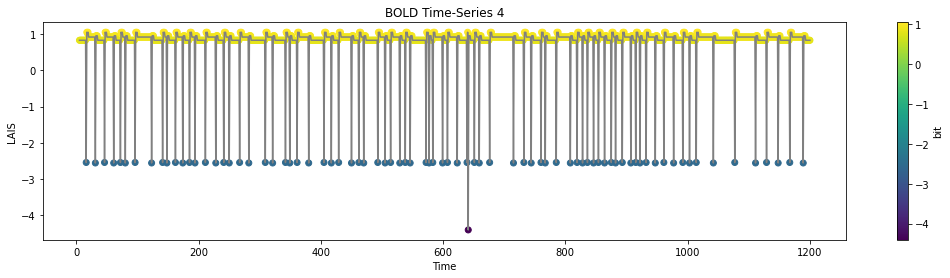

In [8]:
lais_4 = local_ais(bold[4],4)

plt.figure(figsize=(18,4))
plt.plot(np.arange(5,len(lais_4)+5), lais_4, c="grey")
plt.scatter(np.arange(5,len(lais_4)+5), lais_4, c=lais_4)
plt.xlabel("Time")
plt.ylabel("LAIS")
plt.title("BOLD Time-Series 4")
plt.colorbar(label="bit")

A negative active information storage indicates a kind of "break", when the combination of a particular past w/ with a particular present is "misinformative" (the system is behaving as if the past and future are decoupled). 

### Local Transfer Entropy

Recall that transfer entropy is:

\begin{equation}
TE(X \rightarrow Y) = MI(X_{t-1}^{-l} ; Y_t | Y_{t-1}^{-k})
\end{equation}

It is the amount of information $X$'s past provides about $Y$'s future above and beyond what $Y$ provides about it's own future. As a conditional mutual information, we can also do a local TE:

\begin{equation}
LTE(X \rightarrow Y) = \log\big(\frac{P(X_{t-1}^{-l} , Y_t | Y_{t-1}^{-k})}{P(X_{t-1}^{-l}| Y_{t-1}^{-k}) P(Y_t | Y_{t-1}^{-k})} \big)
\end{equation}

This looks like a mass of indexing, but it follows directly from the local conditional mutual information. 

What does this mean? 

For two time-series, the LTE gives a measure of *how much* information is moving from $X$ to $Y$ at a given moment in time: one way to think about this is how much information (in bits) does knowing the state of $X$ at time $t$ about the state of $Y$ at time $t+1$ (conditioned on $Y$'s own history, of course). 

Consider the example of two coupled time-series representing the market values of two companies - we can ask, on average, how much information is flowing from Firm A to Firm B by computing the standard transfer entropy, but by "unrolling" it, we can look at what moments in time are driving that directed coupling. A large shock to one which perturbs the other might provide a *lot* of local information, while standard, day-to-day fluctuations aren't as strongly predictive of each-other. 

## Uses for Local Information Measures

Local information dynamics are excellent when you have some other time-resolved dataset that describes the overall behavior of the system. For instance, in financial analysis, local infomration measures can be correlated against events happening in the news to try and understand how activity in the world informs markets. If you are doing some kind of molecular biology analysis, you might be interested in how the transient binding of a ligand to a receptor changes information flow into or out of a cell. 

#### Spacial Localization 

Information can also be localized spatially as well as temporally. The overall equations are the same, although instead of looking at the instantanious information in time, you restrict your analysis to a single element of the system. For example, consider this image, from Joe Lizier's PhD thesis that gives a measure of local information transfer at specific cells in a Rule 110 cellular automata. 

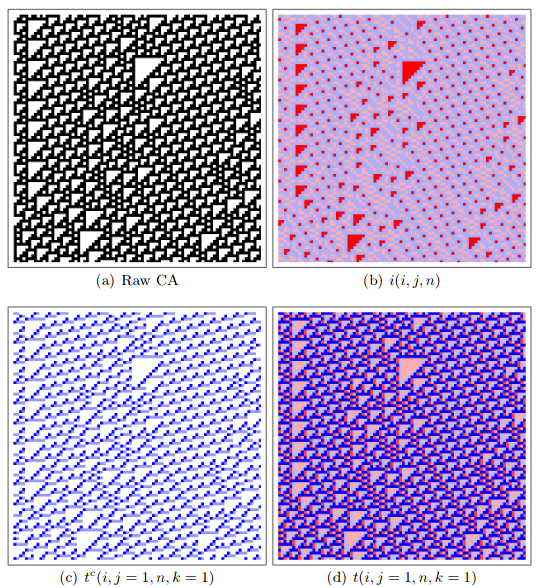

This is kind of analysis of ECA has become very popular, and generalized to random Boolean networks, flocking bird models, and other canonical toy models in complex systems science. 

Spacial localization may be particularly interesting for folks with social media data, where local information dynamics can be extracted from single individuals at particular moments in time, potentially providing a lot of insight into how individuals participate in larger social dynamics. For instance, local active information storage might be useful to understanding predictable vs. unpredictable individuals, local transfer entropy could be used to understand how particular stimuli influence behavior, etc. 